In [ ]:
#|default_exp core

# Claudio's source

This is the 'literate' source code for Claudio. You can view the fully rendered version of the notebook [here](https://answerdotai.github.io/claudio/core.html), or you can clone the git repo and run the [interactive notebook](https://github.com/AnswerDotAI/claudio/blob/main/00_core.ipynb) in Jupyter. The notebook is converted the [Python module claudio/core.py](https://github.com/AnswerDotAI/claudio/blob/main/claudio/core.py) using [nbdev](https://nbdev.fast.ai/). The goal of this source code is to both create the Python module, and also to teach the reader *how* it is created, without assuming much existing knowledge about Claude's API.

Most of the time you'll see that we write some source code *first*, and then a description or discussion of it *afterwards*.

## Setup

In [ ]:
import os
# os.environ['ANTHROPIC_LOG'] = 'debug'

To print every HTTP request and response in full, uncomment the above line. This functionality is provided by Anthropic's SDK.

In [ ]:
#| export
import inspect, typing, mimetypes, base64, json, xml.etree.ElementTree as ET
from collections import abc
try: from IPython import display
except: display=None

from anthropic import Anthropic
from anthropic.types import Usage, TextBlock, Message
from anthropic.types.beta.tools import ToolsBetaMessage, tool_use_block

from fastcore.docments import docments
from fastcore.utils import *

In [ ]:
#| export
empty = inspect.Parameter.empty

:::{.callout-tip}

Note the "Exported source" collapsible widget below. That shows that this piece of code will be exported into the python module that this notebook creates. No other code will be included -- any other code in this notebook is just for demonstration, documentation, and testing.

You can toggle expanding/collapsing the source code of all exported sections by using the `</> Code` menu in the top right of the rendered notebook page.

:::

In [ ]:
#| exports
models = 'claude-3-opus-20240229','claude-3-sonnet-20240229','claude-3-haiku-20240307'

These are the current versions of Anthropic's model at the time of writing.

In [ ]:
model = models[-1]

For examples, we'll use Haiku, since it's fast and cheap (and surprisingly good!)

## Antropic SDK

In [ ]:
cli = Anthropic()

This is what Anthropic's SDK provides for interacting with Python. To use it, pass it a list of *messages*, with *content* and a *role*. The roles should alternate between *user* and *assistant*.

:::{.callout-tip}

After the code below you'll see an indented section with an orange vertical line on the left. This is used to show the *result* of running the code above. Because the code is running in a Jupyter Notebook, we don't have to use `print` to display results, we can just type the expression directly, as we do with `r` here.

:::

In [ ]:
m = {'role': 'user', 'content': "I'm Jeremy"}
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

Message(id='msg_01HDG6FBAy3XQ7StdycrRaBw', content=[TextBlock(text="It's nice to meet you, Jeremy! I'm an artificial intelligence assistant created by Anthropic. Let me know if you have any questions or if there's anything I can help you with.", type='text')], model='claude-3-haiku-20240307', role='assistant', stop_reason='end_turn', stop_sequence=None, type='message', usage=Usage(input_tokens=10, output_tokens=43))

### Formatting output

That output is pretty long and hard to read, so let's clean it up. We'll start by pulling out the `Content` part of the message.
To do that, we're going to write our first function which will be included to the `claudia/core.py` module.

:::{.callout-tip}

This is the first exported function or class we're creating (the previous export was of a variable). In the rendered version of the notebook for these you'll see 3 things, in this order:

- The signature (with the symbol name as a heading, with a horizontal rule above)
- A table of paramater docs (if provided)
- The doc string (in italics).
- The source code (in a collapsible "Exported source" block)

After that, we generally provide a bit more detail on what we've created, and why, along with a sample usage.

:::

In [ ]:
#| exports
def find_block(r:abc.Mapping, # The message to look in
               blk_type:type=TextBlock  # The type of block to find
              ):
    "Find the first block of type `blk_type` in `r.content`."
    return first(o for o in r.content if isinstance(o,blk_type))

This makes it easier to grab the needed parts of Claude's responses, which can include multiple pieces of content. By default, we look for the first text block. That will generally have the content we want to display.

In [ ]:
find_block(r)

TextBlock(text="It's nice to meet you, Jeremy! I'm an artificial intelligence assistant created by Anthropic. Let me know if you have any questions or if there's anything I can help you with.", type='text')

In [ ]:
#| exports
def contents(r):
    "Helper to get the contents from Claude response `r`."
    blk = find_block(r)
    if not blk: blk = r.content[0]
    return blk.text.strip() if hasattr(blk,'text') else blk

For display purposes, we often just want to show the text itself.

In [ ]:
contents(r)

"It's nice to meet you, Jeremy! I'm an artificial intelligence assistant created by Anthropic. Let me know if you have any questions or if there's anything I can help you with."

In [ ]:
#| exports
@patch
def _repr_markdown_(self:(ToolsBetaMessage,Message)):
    det = '\n- '.join(f'{k}: {v}' for k,v in self.dict().items())
    return f"""{contents(self)}

<details>

- {det}

</details>"""

Jupyter looks for a `_repr_markdown_` method in displayed objects; we add this in order to display just the content text, and collapse full details into a hideable section. Note that `patch` is from [fastcore](https://fastcore.fast.ai/), and is used to add (or replace) functionality in an existing class. We pass the class(es) that we want to patch as type annotations to `self`. In this case, `_repr_markdown_` is being added to Anthropic's `ToolsBetaMessage` and `Message` classes, so when we display the message now we just see the contents, and the details are hidden away in a collapsible details block.

In [ ]:
r

It's nice to meet you, Jeremy! I'm an artificial intelligence assistant created by Anthropic. Let me know if you have any questions or if there's anything I can help you with.

<details>

- id: msg_01HDG6FBAy3XQ7StdycrRaBw
- content: [{'text': "It's nice to meet you, Jeremy! I'm an artificial intelligence assistant created by Anthropic. Let me know if you have any questions or if there's anything I can help you with.", 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 10, 'output_tokens': 43}

</details>

One key part of the response is the `usage` key, which tells us how many tokens we used by returning a `Usage` object.

We'll add some helpers to make things a bit cleaner for creating and formatting these objects.

In [ ]:
r.usage

Usage(input_tokens=10, output_tokens=43)

In [ ]:
#| exports
def usage(inp=0, # Number of input tokens
          out=0  # Number of output tokens
         ):
    "Slightly more concise version of `Usage`."
    return Usage(input_tokens=inp, output_tokens=out)

The constructor provided by Anthropic is rather verbose, so we clean it up a bit, using a lowercase version of the name.

In [ ]:
usage(5)

Usage(input_tokens=5, output_tokens=0)

In [ ]:
#| exports
@patch(as_prop=True)
def total(self:Usage): return self.input_tokens+self.output_tokens

Adding a `total` property to `Usage` makes it easier to see how many tokens we've used up altogether.

In [ ]:
usage(5,1).total

6

In [ ]:
#| exports
@patch
def __repr__(self:Usage): return f'In: {self.input_tokens}; Out: {self.output_tokens}; Total: {self.total}'

In python, patching `__repr__` let's us change how an object is displayed.

In [ ]:
r.usage

In: 10; Out: 43; Total: 53

In [ ]:
#| exports
@patch
def __add__(self:Usage, b):
    return usage(self.input_tokens+b.input_tokens, self.output_tokens+b.output_tokens)

And, patching `__add__` let's make `+` work on a class.

In [ ]:
r.usage+r.usage

In: 20; Out: 86; Total: 106

### Creating messages

Creating correctly formatted `dict`s from scratch every time isn't very handy, so next up we'll add helpers for this.

In [ ]:
def mk_msg(content, role='user', **kw):
    return dict(role=role, content=content, **kw)

We make things a bit more convenient by writing a function to create a message for us.

:::{.callout-note}

You may have noticed that we didn't export the `mk_msg` function (i.e. there's no "Exported source" block around it). That's because we'll need more functionality in our final version than this version has -- so we'll be defining a more complete version later. Rather than refactoring/editing in notebooks, often it's helpful to simply gradually build up complexity by re-defining a symbol.

:::

In [ ]:
prompt = "I'm Jeremy"
m = mk_msg(prompt)
m

{'role': 'user', 'content': "I'm Jeremy"}

In [ ]:
r = cli.messages.create(messages=[m], model=model, max_tokens=100)
r

It's nice to meet you, Jeremy! As an AI assistant, I don't have a personal identity, but I'm happy to chat with you and try my best to help out however I can. Please feel free to ask me anything.

<details>

- id: msg_01JH641RNBQ67FNYwnje5Yxp
- content: [{'text': "It's nice to meet you, Jeremy! As an AI assistant, I don't have a personal identity, but I'm happy to chat with you and try my best to help out however I can. Please feel free to ask me anything.", 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 10, 'output_tokens': 52}

</details>

In [ ]:
#| exports
def mk_msgs(msgs, **kw):
    "Helper to set 'assistant' role on alternate messages."
    if isinstance(msgs,str): msgs=[msgs]
    return [mk_msg(o, ('user','assistant')[i%2], **kw) for i,o in enumerate(msgs)]

LLMs, including Claude, don't actually have state, but instead dialogs are created by passing back all previous prompts and responses every time. With Claude, they always alternate *user* and *assistant*. Therefore we create a function to make it easier to build up these dialog lists.

But to do so, we need to update `mk_msg` so that we can't only pass a `str` as `content`, but can also pass a `dict` or an object with a `content` attr, since these are both types of message that Claude can create. To do so, we check for a `content` key or attr, and use it if found.

In [ ]:
def mk_msg(content, role='user', **kw):
    "Helper to create a `dict` appropriate for a Claude message. `kw` are added as key/value pairs to the message"
    if hasattr(content, 'content'): content,role = content.content,content.role
    if isinstance(content, abc.Mapping): content=content['content']
    return dict(role=role, content=content, **kw)

In [ ]:
msgs = mk_msgs([prompt, r, 'I forgot my name. Can you remind me please?'])
msgs

[{'role': 'user', 'content': "I'm Jeremy"},
 {'role': 'assistant',
  'content': [TextBlock(text="It's nice to meet you, Jeremy! As an AI assistant, I don't have a personal identity, but I'm happy to chat with you and try my best to help out however I can. Please feel free to ask me anything.", type='text')]},
 {'role': 'user', 'content': 'I forgot my name. Can you remind me please?'}]

Now, if we pass this list of messages to Claude, the model treats it as a conversation to respond to.

In [ ]:
cli.messages.create(messages=msgs, model=model, max_tokens=200)

I'm afraid I don't actually know your name. As an AI system, I don't have any stored information about your personal identity or name. I was just addressing you as "Jeremy" based on what you told me at the start of our conversation. If you've forgotten your own name, I don't have a way to remind you of it. Perhaps you could try retracing your steps or looking at any identification you may have to jog your memory.

<details>

- id: msg_01FKQ45RKFwWJwu5nDXs5SAY
- content: [{'text': 'I\'m afraid I don\'t actually know your name. As an AI system, I don\'t have any stored information about your personal identity or name. I was just addressing you as "Jeremy" based on what you told me at the start of our conversation. If you\'ve forgotten your own name, I don\'t have a way to remind you of it. Perhaps you could try retracing your steps or looking at any identification you may have to jog your memory.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 76, 'output_tokens': 98}

</details>

## Client

In [ ]:
#| exports
class Client:
    def __init__(self, model, cli=None):
        "Basic Anthropic messages client."
        self.model,self.use = model,Usage(input_tokens=0,output_tokens=0)
        self.c = (cli or Anthropic())

We'll create a simple `Client` for `Anthropic` which tracks usage stores the model to use. We don't add any methods right away -- instead we'll use `patch` for that so we can add and document them incrementally.

In [ ]:
c = Client(model)
c.use

In: 0; Out: 0; Total: 0

In [ ]:
#| exports
@patch
def _r(self:Client, r:ToolsBetaMessage):
    "Store the result of the message and accrue total usage."
    self.result = r
    self.use += r.usage
    return r

We use a `_` prefix on private methods, but we document them here in the interests of literate source code.

`_r` will be used each time we get a new result, to track usage and also to keep the result available for later.

In [ ]:
c._r(r)
c.use

In: 10; Out: 52; Total: 62

In [ ]:
#| exports
@patch
def __call__(self:Client, msgs, sp='', temp=0, maxtok=4096, stop=None, **kw):
    "Make a call to Claude without streaming."
    r = self.c.beta.tools.messages.create(
        model=self.model, messages=mk_msgs(msgs), max_tokens=maxtok, system=sp, temperature=temp, stop_sequences=stop, **kw)
    return self._r(r)

Defining `__call__` let's us use an object like a function (i.e it's *callable*). We use it as a small wrapper over `messages.create`.

In [ ]:
c('Hi')

Hello! How can I assist you today?

<details>

- id: msg_01Vr6t6QdodntSMvHthnRDBc
- content: [{'text': 'Hello! How can I assist you today?', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 8, 'output_tokens': 12}

</details>

In [ ]:
c.use

In: 18; Out: 64; Total: 82

In [ ]:
#| exports
@patch
def stream(self:Client, msgs, sp='', temp=0, maxtok=4096, stop=None, **kw):
    "Make a call to Claude, streaming the result."
    with self.c.messages.stream(model=self.model, messages=mk_msgs(msgs), max_tokens=maxtok,
                                system=sp, temperature=temp, stop_sequences=stop, **kw) as s:
        yield from s.text_stream
        return self._r(s.get_final_message())

We also define a wrapper over `messages.stream`, which is like `messages.create`, but streams the response back incrementally.

In [ ]:
for o in c.stream('Hi'): print(o, end='')

Hello! How can I assist you today?

In [ ]:
c.use

In: 26; Out: 76; Total: 102

## Tool use

[Tool use](https://docs.anthropic.com/claude/docs/tool-use) lets Claude use external tools. The API uses JSON schema, so we need a way to map Python functions to JSON.

We'll use [docments](https://fastcore.fast.ai/docments.html) to make defining Python functions as ergonomic as possible. Each parameter (and the return value) should have a type, and a docments comment with the description of what it is. Here's an example:

In [ ]:
def silly_sum(
    a:int, # First thing to sum
    b:int=1, # Second thing to sum
    c:list[int]=None, # A pointless argument
) -> int: # The sum of the inputs
    "Adds a + b."
    return a + b

This is what `docments` makes of that:

In [ ]:
d = docments(silly_sum, full=True)
d

```json
{ 'a': { 'anno': <class 'int'>,
         'default': <class 'inspect._empty'>,
         'docment': 'First thing to sum'},
  'b': {'anno': <class 'int'>, 'default': 1, 'docment': 'Second thing to sum'},
  'c': {'anno': list[int], 'default': None, 'docment': 'A pointless argument'},
  'return': { 'anno': <class 'int'>,
              'default': <class 'inspect._empty'>,
              'docment': 'The sum of the inputs'}}
```

Note that this is an [AttrDict](https://fastcore.fast.ai/basics.html#attrdict) so we can treat it like an object, *or* a dict:

In [ ]:
d.a.docment, d['a']['anno']

('First thing to sum', int)

In [ ]:
#| exports
def _types(t:type)->tuple[str,Optional[str]]:
    "Tuple of json schema type name and (if appropriate) array item name."
    tmap = {int:"integer", float:"number", str:"string", bool:"boolean", list:"array", dict:"object"}
    if getattr(t, '__origin__', None) in  (list,tuple): return "array", tmap.get(t.__args__[0], "object")
    else: return tmap.get(t, "object"), None

This internal function is needed to convert Python types into JSON schema types.

In [ ]:
_types(list[int]), _types(int)

(('array', 'integer'), ('integer', None))

In [ ]:
#| exports
def _param(name, info):
    "json schema parameter given `name` and `info` from docments full dict."
    paramt,itemt = _types(info.anno)
    pschema = dict(type=paramt, description=info.docment)
    if itemt: pschema["items"] = {"type": itemt}
    if info.default is not empty: pschema["default"] = info.default
    return pschema

This private function converts a key/value pair from the `docments` structure into the `dict` that will be needed for the schema.

In [ ]:
n,o = first(d.items())
print(n,'//', o)
_param(n, o)

a // {'docment': 'First thing to sum', 'anno': <class 'int'>, 'default': <class 'inspect._empty'>}


{'type': 'integer', 'description': 'First thing to sum'}

In [ ]:
#| exports
def get_schema(f:callable)->dict:
    "Convert function `f` into a JSON schema `dict` for tool use."
    d = docments(f, full=True)
    ret = d.pop('return')
    paramd = {
        'type': "object",
        'properties': {n:_param(n,o) for n,o in d.items()},
        'required': [n for n,o in d.items() if o.default is empty]
    }
    desc = f.__doc__
    if ret.anno is not empty: desc += f'\n\nReturns:\n- type: {_types(ret.anno)[0]}'
    if ret.docment: desc += f'\n- description: {ret.docment}'
    return dict(name=f.__name__, description=desc, input_schema=paramd)

Putting this all together, we can now test getting a schema from `silly_sum`. The tool use spec doesn't support return annotations directly, so we put that in the description instead.

In [ ]:
s = get_schema(silly_sum)
desc = s.pop('description')
print(desc)
s

Adds a + b.

Returns:
- type: integer
- description: The sum of the inputs


{'name': 'silly_sum',
 'input_schema': {'type': 'object',
  'properties': {'a': {'type': 'integer', 'description': 'First thing to sum'},
   'b': {'type': 'integer',
    'description': 'Second thing to sum',
    'default': 1},
   'c': {'type': 'array',
    'description': 'A pointless argument',
    'items': {'type': 'integer'},
    'default': None}},
  'required': ['a']}}

We'll now get ready to test this out -- first we need a function that Claude can call; we'll write a simple function that adds numbers together:

In [ ]:
def sums(
    # First thing to sum
    a:int,
    # Second thing to sum
    b:int=1
# The sum of the inputs
) -> int:
    "Adds a + b."
    return a + b

In [ ]:
a,b = 604542,6458932
pr = f"What is {a}+{b}?"
sp = "You must use the `sums` function instead of adding yourself, but don't mention what tools you use."
tools=[get_schema(sums)]

We'll start a dialog with Claude now. We'll store the messages of our dialog in `msgs`. The first message will be our prompt `pr`, and we'll pass our `tools` schema.

In [ ]:
msgs = mk_msgs(pr)
r = c(msgs, sp=sp, tools=tools)
r

ToolUseBlock(id='toolu_01CsuZfPAas75MkDABXAvjWD', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: msg_01StvQvvrnwaBtuUwHQLrpFt
- content: [{'id': 'toolu_01CsuZfPAas75MkDABXAvjWD', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: tool_use
- stop_sequence: None
- type: message
- usage: {'input_tokens': 414, 'output_tokens': 72}

</details>

When Claude decides that it should use a tool, it passes back a `ToolUseBlock` with the name of the tool to call, and the params to use.

We need to append the response to the dialog so Claude knows what's happening (since it's stateless).

In [ ]:
msgs.append(mk_msg(r))

We don't want to allow it to call just any possible function (that would be a security disaster!) so we create a *namespace* -- that is, a dictionary of allowable function names to call.

In [ ]:
#| exports
def mk_ns(*funcs:list[callable]) -> dict[str,callable]:
    "Create a `dict` of name to function in `funcs`, to use as a namespace"
    return {f.__name__:f for f in funcs}

In [ ]:
ns = mk_ns(sums)
ns

{'sums': <function __main__.sums(a: int, b: int = 1) -> int>}

In [ ]:
#| exports
def call_func(tr, ns=None):
    "Call the function in the tool response `tr`, using namespace `ns`."
    if ns is None: ns=globals()
    if not isinstance(ns, abc.Mapping): ns = mk_ns(*ns)
    fc = find_block(r, tool_use_block.ToolUseBlock)
    return ns[fc.name](**fc.input)

We can now use the function requested by Claude. We look it up in `ns`, and pass in the provided parameters.

In [ ]:
res = call_func(r, ns=ns)
res

7063474

In [ ]:
#| exports
def mk_toolres(r, res=None, ns=None):
    "Create a `tool_result` message from response `r`."
    if not hasattr(r, 'content'): return r
    tool = first(o for o in r.content if isinstance(o,tool_use_block.ToolUseBlock))
    if not tool: return r
    if res is None: res = call_func(r, ns)
    tr = dict(type="tool_result", tool_use_id=tool.id, content=str(res))
    return mk_msg([tr])

In order to tell Claude the result of the tool call, we pass back a `tool_result` message, created by calling `call_func`.

In [ ]:
tr = mk_toolres(r, res=res, ns=ns)
tr

{'role': 'user',
 'content': [{'type': 'tool_result',
   'tool_use_id': 'toolu_01CsuZfPAas75MkDABXAvjWD',
   'content': '7063474'}]}

We add this to our dialog, and now Claude has all the information it needs to answer our question.

In [ ]:
msgs.append(tr)
contents(c(msgs, sp=sp, tools=tools))

'The sum of 604542 and 6458932 is 7063474.'

## Chat

Rather than manually adding the responses to a dialog, we'll create a simple `Chat` class to do that for us, each time we make a request. We'll also store the system prompt and tools here, to avoid passing them every time.

In [ ]:
#| exports
class Chat:
    def __init__(self, model=None, cli=None, sp='', tools=None):
        "Anthropic chat client."
        assert model or cli
        self.c = (cli or Client(model))
        self.h,self.sp,self.tools = [],sp,tools

The class stores the `Client` that will provide the responses in `c`, and a history of messages in `h`.

In [ ]:
sp = "If asked to add things up, use the `sums` function instead of doing it yourself. Never mention what tools you use."
chat = Chat(model, sp=sp)
chat.c.use, chat.h

(In: 0; Out: 0; Total: 0, [])

In [ ]:
#| exports
def _add_prefill(prefill, r):
    "Add `prefill` to the start of response `r`, since Claude doesn't include it otherwise"
    if not prefill: return
    blk = find_block(r)
    blk.text = prefill + blk.text

Claude supports adding an extra `assistant` message at the end, which contains the *prefill* -- i.e. the text we want Claude to assume the response starts with. However Claude doesn't actually repeat that in the response, so for convenience we'll add it.

In [ ]:
#| exports
@patch
def __call__(self:Chat, pr, temp=0, maxtok=4096, stop=None, ns=None, prefill='', **kw):
    if ns is None: ns=self.tools
    if isinstance(pr,str): pr = pr.strip()
    self.h.append(mk_toolres(pr, ns=ns))
    if self.tools: kw['tools'] = [get_schema(o) for o in self.tools]
    res = self.c(self.h + ([prefill.strip()] if prefill else []), sp=self.sp, temp=temp, maxtok=maxtok, stop=stop, **kw)
    _add_prefill(prefill, res)
    self.h.append(mk_msg(res, role='assistant'))
    return res

The `__call__` method just passes the request along to the `Client`, but rather than just passing in this one prompt, it appends it to the history and passes it all along. As a result, we now have state!

In [ ]:
chat("I'm Jeremy")
contents(chat("What's my name?"))

'Your name is Jeremy, as you mentioned earlier.'

Let's try out prefill too:

In [ ]:
q = "Concisely, what is the meaning of life?"
pref = 'According to Douglas Adams,'

In [ ]:
chat(q, prefill=pref)

According to Douglas Adams,  the answer is 42.

<details>

- id: msg_01PpZHCVVQk773rRjbBu38U1
- content: [{'text': 'According to Douglas Adams,  the answer is 42.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 129, 'output_tokens': 10}

</details>

In [ ]:
#| exports
@patch
def stream(self:Chat, pr, temp=0, maxtok=4096, stop=None, prefill='', **kw):
    "Add a prompt and get a response from the chat dialog, streaming the result"
    if isinstance(pr,str): pr = pr.strip()
    self.h.append(pr)
    if prefill: yield(prefill)
    yield from self.c.stream(self.h + ([prefill.strip()] if prefill else []), sp=self.sp, temp=temp, maxtok=maxtok, stop=stop, **kw)
    _add_prefill(prefill, self.c.result)
    self.h.append(mk_msg(self.c.result, role='assistant'))

In [ ]:
chat = Chat(model, sp=sp)
for o in chat.stream("I'm Jeremy"): print(o, end='')

It's nice to meet you, Jeremy! I'm an AI assistant created by Anthropic. I'm here to help with any tasks or questions you may have. Please let me know if there's anything I can assist you with.

In [ ]:
for o in chat.stream(q, prefill=pref): print(o, end='')

According to Douglas Adams,  the answer is 42.

### Chat tool use

We automagically get streamlined tool use as well:

In [ ]:
pr = f"What is {a}+{b}?"
pr

'What is 604542+6458932?'

In [ ]:
chat = Chat(model, sp=sp, tools=[sums])
r = chat(pr)
r

ToolUseBlock(id='toolu_018m6yuZwQtn7xZozny37CrZ', input={'a': 604542, 'b': 6458932}, name='sums', type='tool_use')

<details>

- id: msg_01MSiGKYedwdpr41VciqydB7
- content: [{'id': 'toolu_018m6yuZwQtn7xZozny37CrZ', 'input': {'a': 604542, 'b': 6458932}, 'name': 'sums', 'type': 'tool_use'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: tool_use
- stop_sequence: None
- type: message
- usage: {'input_tokens': 418, 'output_tokens': 72}

</details>

In [ ]:
chat(r)

The sum of 604542 and 6458932 is 7063474.

<details>

- id: msg_016NBFCx5L3HMvY5kwVDdjDE
- content: [{'text': 'The sum of 604542 and 6458932 is 7063474.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 505, 'output_tokens': 23}

</details>

It should be correct, because it actually used our Python function to do the addition. Let's check:

In [ ]:
a+b

7063474

## Images

Claude can handle image data as well. As everyone knows, when testing image APIs you have to use a cute puppy.

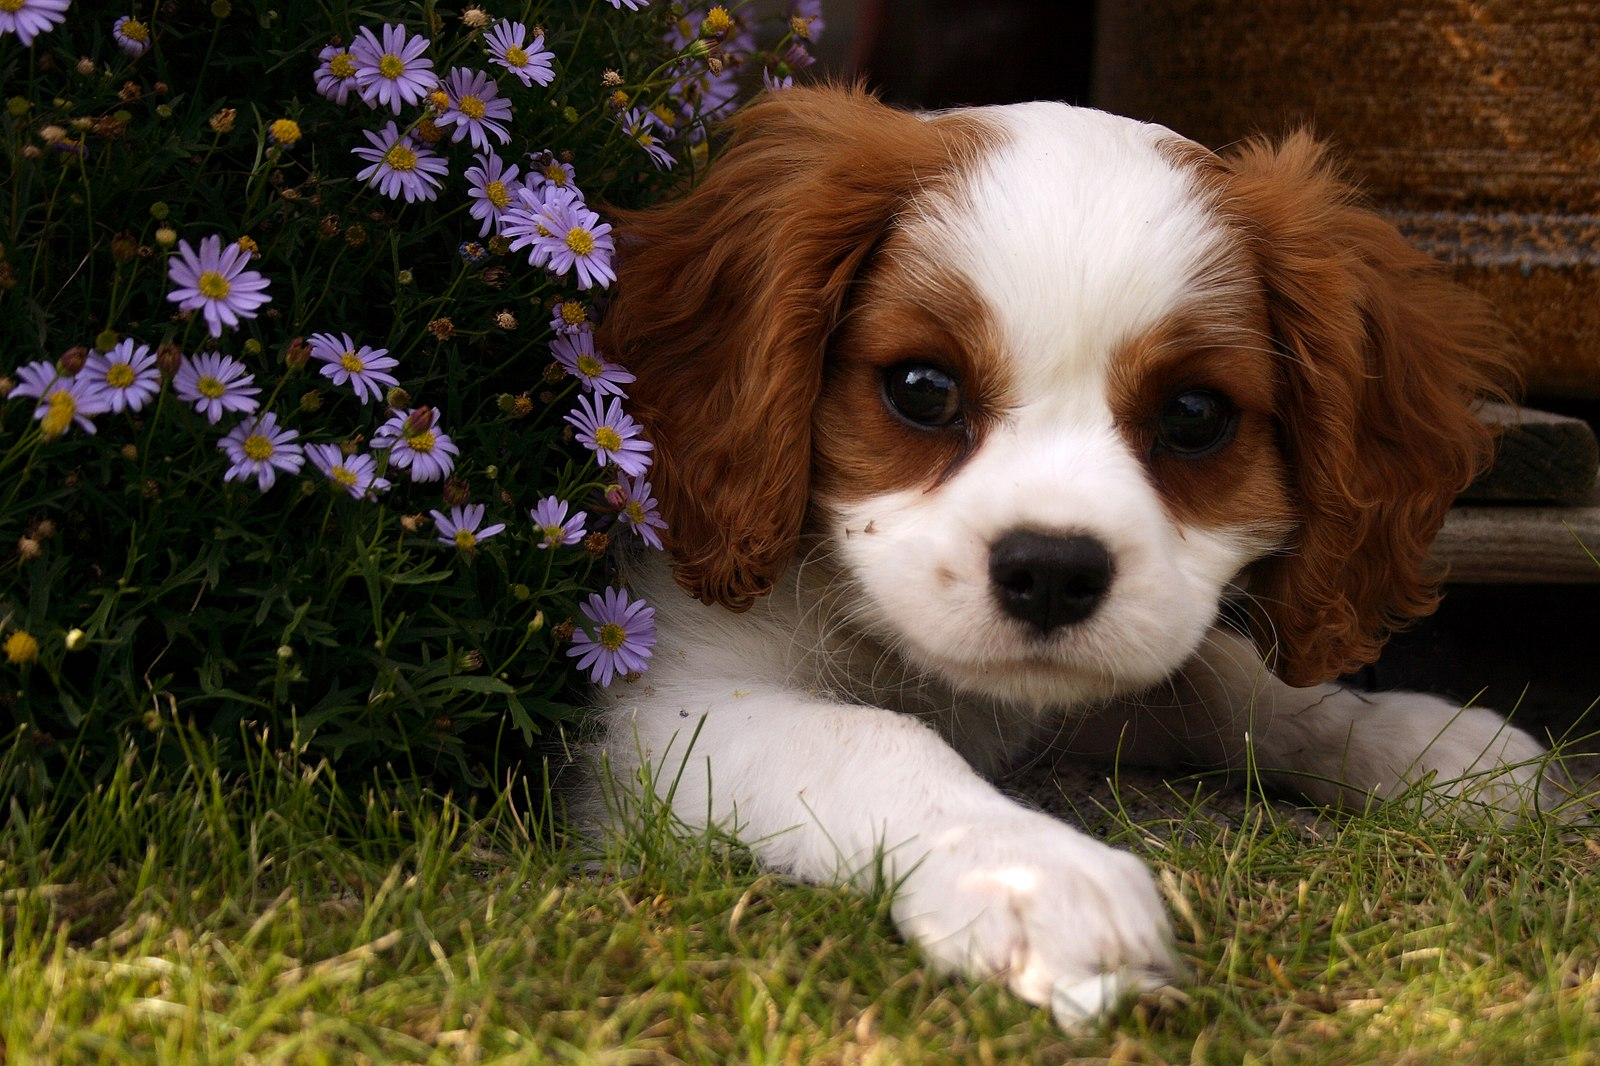

In [ ]:
# Image is Cute_dog.jpg from Wikimedia
fn = Path('puppy.jpg')
display.Image(filename=fn, width=200)

In [ ]:
img = fn.read_bytes()

In [ ]:
#| exports
def img_msg(data:bytes)->dict:
    "Convert image `data` into an encoded `dict`"
    img = base64.b64encode(data).decode("utf-8")
    mtype = mimetypes.guess_type(fn)[0]
    r = dict(type="base64", media_type=mtype, data=img)
    return {"type": "image", "source": r}

Anthropic have documented the particular `dict` structure that expect image data to be in, so we have a little function to create that for us.

In [ ]:
#| exports
def text_msg(s:str)->dict:
    "Convert `s` to a text message"
    return {"type": "text", "text": s}

A Claude message can be a list of image and text parts. So we've also created a helper for making the text parts.

In [ ]:
q = "In brief, what color flowers are in this image?"
msg = mk_msg([img_msg(img), text_msg(q)])

In [ ]:
c([msg])

The image contains purple and yellow daisy-like flowers, which appear to be daisies or a similar type of flower.

<details>

- id: msg_01GSzzitXbvkzEJtfJquzSXE
- content: [{'text': 'The image contains purple and yellow daisy-like flowers, which appear to be daisies or a similar type of flower.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 1665, 'output_tokens': 29}

</details>

In [ ]:
#| exports
def _mk_content(src):
    "Create appropriate content data structure based on type of content"
    if isinstance(src,str): return text_msg(src)
    if isinstance(src,bytes): return img_msg(src)
    return src

There's not need to manually choose the type of message, since we figure that out from the data of the source data.

In [ ]:
_mk_content('Hi')

{'type': 'text', 'text': 'Hi'}

In [ ]:
#| exports
def mk_msg(content, # A string, list, or dict containing the contents of the message
           role='user', # Must be 'user' or 'assistant'
           **kw):
    "Helper to create a `dict` appropriate for a Claude message. `kw` are added as key/value pairs to the message"
    if hasattr(content, 'content'): content,role = content.content,content.role
    if isinstance(content, abc.Mapping): content=content['content']
    if not isinstance(content, list): content=[content]
    content = [_mk_content(o) for o in content]
    return dict(role=role, content=content, **kw)

When we construct a message, we now use `_mk_content` to create the appropriate parts. Since a dialog contains multiple messages, and a message can contain multiple content parts, to pass a single message with multiple parts we have to use a list containing a single list:

In [ ]:
c([[img, q]])

The image contains purple and yellow daisy-like flowers, which appear to be daisies or a similar type of flower.

<details>

- id: msg_01ArrMvaZoXa1JTjULMentQJ
- content: [{'text': 'The image contains purple and yellow daisy-like flowers, which appear to be daisies or a similar type of flower.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 1665, 'output_tokens': 29}

</details>

:::{.callout-note}

As promised (much!) earlier, we've now finally completed our definition of `mk_msg`, and this version is the one we export to the Python module.

:::

Claude also supports uploading an image without any text, in which case it'll make a general comment about what it sees. You can then use `Chat` to ask questions:

In [ ]:
chat = Chat(model, sp=sp)
chat(img)

The image shows a cute puppy, likely a Cavalier King Charles Spaniel, sitting in a grassy area surrounded by purple daisy flowers. The puppy has a friendly, curious expression on its face as it gazes directly at the camera. The contrast between the puppy's soft, fluffy fur and the vibrant flowers creates a charming and picturesque scene.

<details>

- id: msg_01535kuKhiN6Do5PTcTmTst7
- content: [{'text': "The image shows a cute puppy, likely a Cavalier King Charles Spaniel, sitting in a grassy area surrounded by purple daisy flowers. The puppy has a friendly, curious expression on its face as it gazes directly at the camera. The contrast between the puppy's soft, fluffy fur and the vibrant flowers creates a charming and picturesque scene.", 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 1681, 'output_tokens': 83}

</details>

In [ ]:
chat('What direction is the puppy facing?')

The puppy in the image is facing the camera directly, looking straight ahead with a curious expression.

<details>

- id: msg_01Ge4M4Z4J6ywg9V8cCXy2aN
- content: [{'text': 'The puppy in the image is facing the camera directly, looking straight ahead with a curious expression.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 1775, 'output_tokens': 23}

</details>

In [ ]:
chat('What color is it?')

The puppy in the image has a combination of colors - it has a white and brown/tan coat. The head and ears appear to be a reddish-brown color, while the body is mostly white with some tan/brown patches.

<details>

- id: msg_01JbUH6MvqWMvkF8UJVjo33z
- content: [{'text': 'The puppy in the image has a combination of colors - it has a white and brown/tan coat. The head and ears appear to be a reddish-brown color, while the body is mostly white with some tan/brown patches.', 'type': 'text'}]
- model: claude-3-haiku-20240307
- role: assistant
- stop_reason: end_turn
- stop_sequence: None
- type: message
- usage: {'input_tokens': 1806, 'output_tokens': 53}

</details>

## XML helpers

Claude works well with XML inputs, but XML can be a bit clunky to work with manually. Therefore, we create a couple of more streamlined approaches for XML generation. You don't need to use these if you don't find them useful -- you can always just use plain strings for XML directly.

In [ ]:
#| exports
def xt(tag, c=None, **kw):
    "Helper to create appropriate data structure for `to_xml`."
    kw = {k.lstrip('_'):str(v) for k,v in kw.items()}
    return tag,c,kw

An XML node contains a tag, optional children, and optional attributes. `xt` creates a tuple of these three things, which we will use to general XML shortly. Attributes are passed as kwargs; since these might conflict with reserved words in Python, you can optionally add a `_` prefix and it'll be stripped off.

In [ ]:
xt('x-custom', ['hi'], _class='bar')

('x-custom', ['hi'], {'class': 'bar'})

In [ ]:
#| exports
g = globals()
tags = 'div img h1 h2 h3 h4 h5 p hr span html'.split()
for o in tags: g[o] = partial(xt, o)

If you have to use a lot of tags of the same type, it's convenient to use `partial` to create specialised functions for them. Here, we're creating functions for some common HTML tags. Here's an example of using them:

In [ ]:
a = html([
    p('This is a paragraph'),
    hr(),
    img(src='http://example.prg'),
    div([
        h1('This is a header'),
        h2('This is a sub-header', style='k:v'),
    ], _class='foo')
])
a

('html',
 [('p', 'This is a paragraph', {}),
  ('hr', None, {}),
  ('img', None, {'src': 'http://example.prg'}),
  ('div',
   [('h1', 'This is a header', {}),
    ('h2', 'This is a sub-header', {'style': 'k:v'})],
   {'class': 'foo'})],
 {})

In [ ]:
#| exports
def hl_md(s, lang='xml'):
    "Syntax highlight `s` using `lang`."
    if display: return display.Markdown(f'```{lang}\n{s}\n```')
    print(s)

When we display XML in a notebook, it's nice to highlight it, so we create a function to simplify that:

In [ ]:
hl_md('<test><xml foo="bar">a child</xml></test>')

```xml
<test><xml foo="bar">a child</xml></test>
```

In [ ]:
#| exports
def to_xml(node, hl=False):
    "Convert `node` to an XML string."
    def mk_el(tag, cs, attrs):
        el = ET.Element(tag, attrib=attrs)
        if isinstance(cs, list): el.extend([mk_el(*o) for o in cs])
        elif cs is not None: el.text = str(cs)
        return el

    root = mk_el(*node)
    ET.indent(root)
    res = ET.tostring(root, encoding='unicode')
    return hl_md(res) if hl else res

Now we can convert that HTML data structure we created into XML:

In [ ]:
to_xml(a, hl=True)

```xml
<html>
  <p>This is a paragraph</p>
  <hr />
  <img src="http://example.prg" />
  <div class="foo">
    <h1>This is a header</h1>
    <h2 style="k:v">This is a sub-header</h2>
  </div>
</html>
```

In [ ]:
#| exports
def json_to_xml(d:dict, rnm:str)->str:
    "Convert `d` to XML with root name `rnm`."
    root = ET.Element(rnm)
    def build_xml(data, parent):
        if isinstance(data, dict):
            for key, value in data.items(): build_xml(value, ET.SubElement(parent, key))
        elif isinstance(data, list):
            for item in data: build_xml(item, ET.SubElement(parent, 'item'))
        else: parent.text = str(data)
    build_xml(d, root)
    ET.indent(root)
    return ET.tostring(root, encoding='unicode')

JSON doesn't map as nicely to XML as the data structure used in the previous section, but for simple XML trees it can be convenient -- for example:

In [ ]:
a = dict(surname='Howard', firstnames=['Jeremy','Peter'],
         address=dict(state='Queensland',country='Australia'))
hl_md(json_to_xml(a, 'person'))

```xml
<person>
  <surname>Howard</surname>
  <firstnames>
    <item>Jeremy</item>
    <item>Peter</item>
  </firstnames>
  <address>
    <state>Queensland</state>
    <country>Australia</country>
  </address>
</person>
```

## Export -

In [ ]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()